# **1.Gerekli modülleri yükle**



In [ ]:
!pip install scikit-image
!pip install matplotlib
!pip install opencv-python
!pip install tensorflow
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 18.5 MB/s eta 0:00:00


# **2.Veri ön işleme**

In [ ]:
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import random as r
import cv2
from skimage.transform import resize

def seg_array(path,end):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    for file in files[:100]: # Bellek hatası vermesin diye belli miktarda veri ile işlem yapıyor
        print(file)
        img = io.imread(file,plugin='simpleitk')
        img = resize(img, (155, 160, 160))
        print(img.shape)
        img[img != 0 ] = 1
        img.astype('float32')

        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)

    return np.array(img_liste,np.float32)

def train_array(path,end):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    for file in files[:100]: # Bellek hatası vermesin diye belli miktarda veri ile işlem yaptırıyorum
        print(file)
        img = io.imread(file,plugin='simpleitk')
        img = resize(img, (155, 160, 160))
        print(img.shape)
        img = (img-img.mean())/ img.std()
        img.astype('float32')

        for slice in range(60,130): # Resimdeki beynin tam olarak görünmüyen kısımları çıkarıyor
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)

    return np.array(img_liste,np.float32)

img_flair = train_array("/content/drive/MyDrive/brats/Training/","**/*Flair*/*.mha")
img_seg = seg_array("/content/drive/MyDrive/brats/Training/","**/*OT*/*.mha")
#img_t2 = train_array("/content/drive/MyDrive/brats/Training/","**/*T2*/*.mha")
#x_train = np.concatenate((img_flair, img_t2), axis=1) # T2 görüntüleri ile flair görüntülerinin birleştirilmesi verileri daha düzgün hale getiriyor buda modelin başarısını arttırıyor.
print(img_flair.shape)
#print(img_t2.shape)
#print(x_train.shape)
print("bitti")

/content/drive/MyDrive/brats/Training/LGG/brats_tcia_pat282_0001/VSD.Brain.XX.O.MR_Flair.40943/VSD.Brain.XX.O.MR_Flair.40943.mha
(155, 160, 160)
/content/drive/MyDrive/brats/Training/HGG/brats_tcia_pat157_0001/VSD.Brain.XX.O.MR_Flair.40863/VSD.Brain.XX.O.MR_Flair.40863.mha
(155, 160, 160)
/content/drive/MyDrive/brats/Training/HGG/brats_tcia_pat469_0001/VSD.Brain.XX.O.MR_Flair.36567/VSD.Brain.XX.O.MR_Flair.36567.mha
(155, 160, 160)
/content/drive/MyDrive/brats/Training/HGG/brats_tcia_pat322_0001/VSD.Brain.XX.O.MR_Flair.36001/VSD.Brain.XX.O.MR_Flair.36001.mha
(155, 160, 160)
/content/drive/MyDrive/brats/Training/HGG/brats_tcia_pat372_0001/VSD.Brain.XX.O.MR_Flair.36096/VSD.Brain.XX.O.MR_Flair.36096.mha
(155, 160, 160)
/content/drive/MyDrive/brats/Training/HGG/brats_tcia_pat242_0001/VSD.Brain.XX.O.MR_Flair.35808/VSD.Brain.XX.O.MR_Flair.35808.mha
(155, 160, 160)
/content/drive/MyDrive/brats/Training/HGG/brats_2013_pat0007_1/VSD.Brain.XX.O.MR_Flair.54548/VSD.Brain.XX.O.MR_Flair.54548.mha
(15

# **Unet** **Modeli**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, UpSampling2D,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import tensorflow as tf

K.set_image_data_format('channels_first')

def dice_coef(y_true, y_pred):
    smooth = 0.005
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def unet_model():

    inputs = Input((1, 160 , 160)) # Resmin giriş boyutunu burdan belirle

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)

    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

model = unet_model()
print("bitti")

bitti


# **3.Eğitim**

Epoch 1/10
175/175 [==============================] - 169s 716ms/step - loss: 0.4060 - dice_coef: 0.5940 - val_loss: 0.9998 - val_dice_coef: 1.5693e-04
Epoch 2/10
175/175 [==============================] - 118s 675ms/step - loss: 0.1589 - dice_coef: 0.8411 - val_loss: 0.3365 - val_dice_coef: 0.6645
Epoch 3/10
175/175 [==============================] - 117s 666ms/step - loss: 0.1202 - dice_coef: 0.8798 - val_loss: 0.2911 - val_dice_coef: 0.7098
Epoch 4/10
175/175 [==============================] - 116s 665ms/step - loss: 0.1088 - dice_coef: 0.8912 - val_loss: 0.2944 - val_dice_coef: 0.7063
Epoch 5/10
175/175 [==============================] - 116s 663ms/step - loss: 0.0997 - dice_coef: 0.9003 - val_loss: 0.3096 - val_dice_coef: 0.6912
Epoch 6/10
175/175 [==============================] - 118s 675ms/step - loss: 0.0995 - dice_coef: 0.9005 - val_loss: 0.3350 - val_dice_coef: 0.6659
Epoch 7/10
175/175 [==============================] - 118s 675ms/step - loss: 0.0883 - dice_coef: 0.9117 - v

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


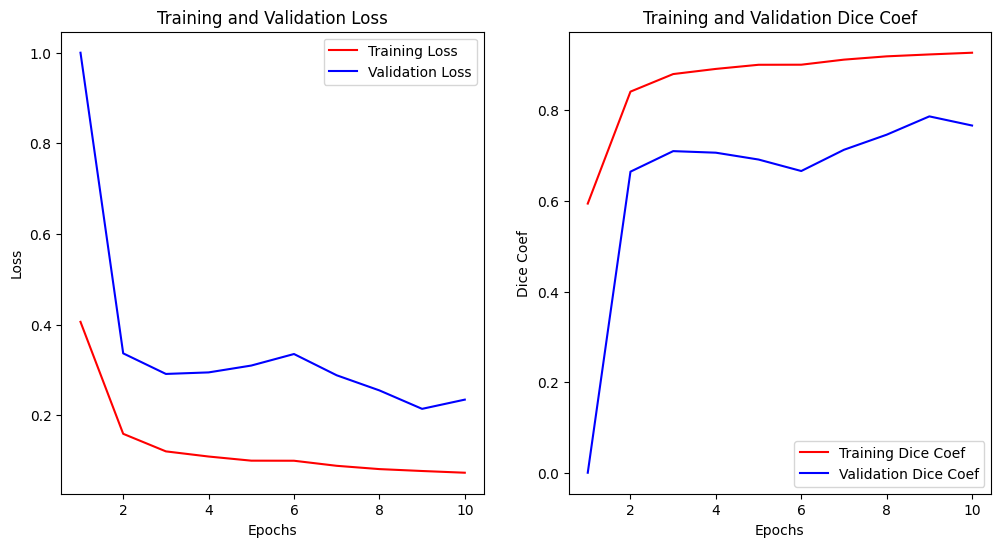

In [ ]:
hist = model.fit(img_flair, img_seg ,validation_split=0.2, epochs=10, shuffle=True, verbose=1 )
model.save("/content/drive/MyDrive/brain1.h5")

# Eğitim geçmişinden metrikleri alın
dice_coef = hist.history['dice_coef']
loss = hist.history['loss']
val_dice_coef = hist.history['val_dice_coef']
val_loss = hist.history['val_loss']

epochs = range(1, len(dice_coef) + 1)

# Loss Grafiği
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Dice Coef Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, dice_coef, 'r', label='Training Dice Coef')
plt.plot(epochs, val_dice_coef, 'b', label='Validation Dice Coef')
plt.title('Training and Validation Dice Coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.legend()

plt.show()


# **4.Tahmin**

1/1 [==============================] - 2s 2s/step


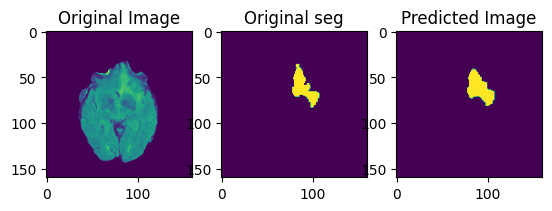

In [ ]:
from tensorflow.keras.models import load_model
from skimage.transform import resize
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np

#model = load_model("/content/drive/MyDrive/brain1.h5", compile=False)

img = np.expand_dims(img_flair[1], axis=0)
predictions = model.predict(img)


# İlk görüntü
plt.subplot(1, 3, 1)  # 1 satır, 2 sütun, 1. sütun
plt.imshow(img[0][0])
plt.title('Original Image')

# İlk görüntü
plt.subplot(1, 3, 2)  # 1 satır, 2 sütun, 1. sütun
plt.imshow(img_seg[1][0])
plt.title('Original seg')

# İkinci görüntü
plt.subplot(1, 3, 3)  # 1 satır, 2 sütun, 2. sütun
plt.imshow(predictions[0][0])
plt.title('Predicted Image')

plt.show()